In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import os
import sys
from scipy import ndimage
from datetime import datetime
from scipy import interpolate
from time import time

#sys.path.append('/home/k0r/analysis/')
sys.path.append('..')
from tools import energyVS06 as energy

In [3]:
def plot_image(image,log=False):
    nx = np.shape(image)[1]
    ny = np.shape(image)[0]
    xpx = np.arange(nx)
    ypx = np.arange(ny)
    if log:
        plt.pcolor(xpx,ypx,np.log10(image),shading='auto')
        #plt.plot(xpx,0.1*ny*(3+np.log10(profx/profx.max())),'r')
        #plt.plot(0.1*nx*(3+np.log10(profy/profy.max())),ypx,'r')
        #plt.ylim([0,ny])
        #plt.xlim([0,nx])
    else:    
        plt.pcolor(xpx,ypx,image,shading='auto')
        sumima = image.sum().sum()
        if sumima > 0:
            profx = image.sum(axis=0) / sumima
            profy = image.sum(axis=1) / sumima
            plt.plot(xpx,ny*0.2*profx/profx.max(),'w')
            plt.plot(1+nx*0.2*profy/profy.max(),ypx,'w')

In [3]:
filedir = ''
filename = 'rawgrid_220429190854-scan-xxpy-image-ypdE.mmp'

a5d_shape = (17, 17, 32, 512, 362)
a5d = np.memmap(filedir+filename,shape=a5d_shape,dtype=np.uint32,mode='r')

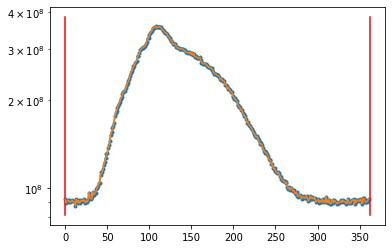

In [4]:
plt.figure()
x3proj = a5d.sum(axis=0).sum(axis=0).sum(axis=0).sum(axis=0)
plt.plot(np.abs(x3proj),'.-')
plt.semilogy()
yl = plt.ylim()



ix3_0 = 0
ix3_1 = len(x3proj)

plt.plot([ix3_0,ix3_0],yl,'r')
plt.plot([ix3_1,ix3_1],yl,'r')
plt.plot(np.arange(ix3_0,ix3_1),x3proj[ix3_0:ix3_1])


[]

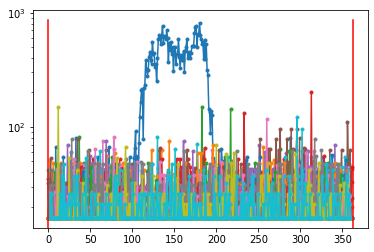

In [7]:
plt.figure()
for i in range(20):
    idx = np.random.randint(np.size(a5d)/np.shape(a5d)[4])
    idx = np.unravel_index(idx,np.shape(a5d)[0:4])
    plt.plot(np.abs(a5d[idx[0],idx[1],idx[2],idx[3],:]),'.-')

    
yl = plt.ylim()
plt.plot([ix3_0,ix3_0],yl,'r')
plt.plot([ix3_1,ix3_1],yl,'r')
plt.semilogy()


## Integrate over dE and reduce size of array


In [8]:
print(np.shape(a5d))
array4d = a5d[:,:,:,:,ix3_0:ix3_1].sum(axis=4).astype(np.float64)
print(np.shape(array4d))
print('Integrated image along x3 over pixels [%i, %i]'%(ix3_0,ix3_1))


del a5d

(17, 17, 32, 512, 362)
(17, 17, 32, 512)
Integrated image along x3 over pixels [0, 362]


## Threshold images

In [9]:
array4d_max = array4d.max()
ix1,ix2,iy1,iy2 = np.where(array4d==array4d_max)
ix1 = ix1[0];  ix2 = ix2[0]; iy1 = iy1[0]; iy2 = iy2[0]
print('Center at index (%i,%i,%i,%i), peak value %.2f'%(ix1,ix2,iy1,iy2,array4d_max))

Center at index (6,9,11,340), peak value 4794440.00


/tmp/ipykernel_2453705/2846621678.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.pcolor(xpx,ypx,np.log10(image),shading='auto')


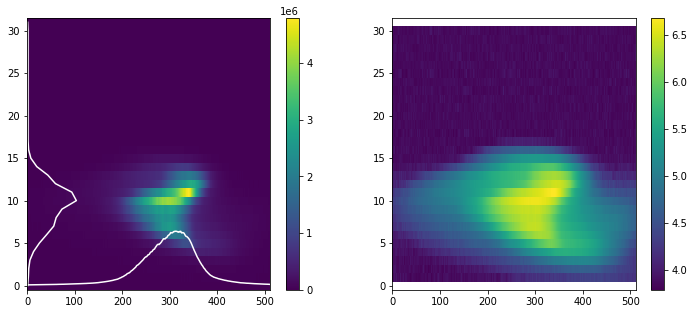

In [10]:
ima = array4d[ix1,ix2,:,:].copy()

plt.figure(figsize=[12,5])
plt.subplot(121)
plot_image(ima,log=False)
plt.colorbar()
plt.subplot(122)
plot_image(ima,log=True)
plt.colorbar()

Threshold at 10^-2.681 fraction of peak


/tmp/ipykernel_2453705/2846621678.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.pcolor(xpx,ypx,np.log10(image),shading='auto')


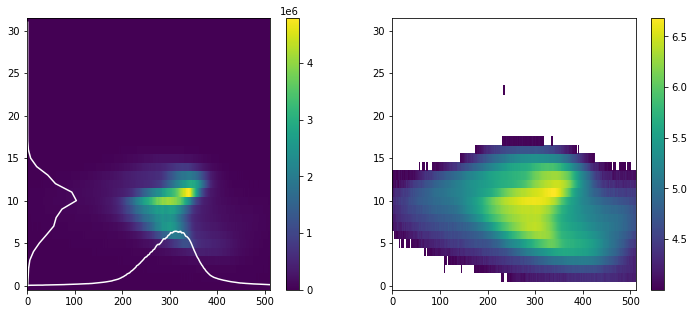

In [11]:
thr = 10000
thr_lvl = thr/array4d_max
print('Threshold at 10^%.3f fraction of peak'%np.log10(thr_lvl))

ima = array4d[ix1,ix2,:,:].copy()
ima[ima<thr] = 0

plt.figure(figsize=[12,5])
plt.subplot(121)
plot_image(ima,log=False)
plt.colorbar()
plt.subplot(122)
plot_image(ima,log=True)
plt.colorbar()

In [12]:
array4d_thr = array4d.copy()
array4d_thr[array4d<thr] = 0

[]

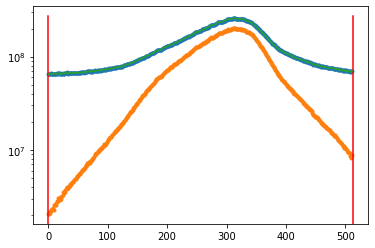

In [13]:

plt.figure()
y3proj = array4d.sum(axis=0).sum(axis=0).sum(axis=0)
y3proj_thr = array4d_thr.sum(axis=0).sum(axis=0).sum(axis=0)
plt.plot(y3proj,'.-')
plt.plot(y3proj_thr,'.-')
yl = plt.ylim()


iy3_0 = 0
iy3_1 = len(y3proj) 


plt.plot([iy3_0,iy3_0],yl,'r')
plt.plot([iy3_1,iy3_1],yl,'r')
plt.plot(np.arange(iy3_0,iy3_1),y3proj[iy3_0:iy3_1])

plt.semilogy()


In [14]:
pwd

'/home/k0r/measurement-analysis/scan3d/scan-xxpy-image-ypdE/220405'

In [15]:
# -- save unthresholded array; threshold is adjustable for viewing
savefilename = 'integrated4D_%s'%(filename)
np.savez_compressed(savefilename, a4d=array4d)